In [ ]:
#default_exp data.datasets.epf

# EPF dataset

> API details.

In [ ]:
#export
from dataclasses import dataclass
from datetime import timedelta
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
from pandas.tseries.frequencies import to_offset

from nixtla.data.datasets.utils import download_file, Info, TimeSeriesDataclass
from nixtla.data.tsdataset import TimeSeriesDataset


In [ ]:
#export
SOURCE_URL = 'https://sandbox.zenodo.org/api/files/da5b2c6f-8418-4550-a7d0-7f2497b40f1b/'

Electricity Price Forecasting meta information

In [ ]:
#export
@dataclass
class NP:
    test_date: str = '2016-12-27'
    name: str = 'NP'

@dataclass
class PJM:
    test_date: str = '2016-12-27'
    name: str = 'PJM'

@dataclass
class BE:
    test_date: str = '2015-01-04'
    name: str = 'BE'

@dataclass
class FR:
    test_date: str = '2015-01-04'
    name: str = 'FR'

@dataclass
class DE:
    test_date: str = '2016-01-04'
    name: str = 'DE'

In [ ]:
#export
EPFInfo = Info(groups=('NP', 'PJM', 'BE', 'FR', 'DE'),
               class_groups=(NP, PJM, BE, FR, DE))

In [ ]:
#export
class EPF:

    #@staticmethod
    def load(directory: str,
             group: str):
             #is_training: bool,
             #days_in_test: int,
             #return_tensor: bool = True): # -> Union[TimeSeriesDataset, TimeSeriesDataclass]
        """
        Downloads and loads EPF data.

        Parameters
        ----------
        directory: str
            Directory where data will be downloaded.
        group: str
            Group name.
            Allowed groups: 'NP', 'PJM', 'BE', 'FR', 'DE'.
        training: bool
            Wheter return training or testing data. Default True.
        days_in_test: int
            Number of days to consider in test.
            Only used when training=True.
        return_tensor: bool
            Wheter return TimeSeriesDataset (tensors, True) or
            TimeSeriesDataclass (dataframes)
        """
        path = Path(directory) / 'epf' / 'datasets'

        EPF.download(directory)

        class_group = EPFInfo.get_group(group)

        file = path / f'{group}.csv'

        df = pd.read_csv(file)

        df.columns = ['ds', 'y'] + \
                     [f'Exogenous{i}' for i in range(1, len(df.columns) - 1)]

        df['unique_id'] = group
        df['ds'] = pd.to_datetime(df['ds'])
        df['week_day'] = df['ds'].dt.dayofweek

        dummies = pd.get_dummies(df['week_day'], prefix='day')
        df = pd.concat([df, dummies], axis=1)

        dummies_cols = [col for col in df \
                        if (col.startswith('day') or col.startswith('hour_'))]

        # last_date_test = pd.to_datetime(class_group.test_date) + \
        #                     timedelta(days=days_in_test)                        

        # if is_training:
        #     df = df.query('ds < @class_group.test_date')
        # else:
        #     last_date_test = pd.to_datetime(class_group.test_date) + \
        #                      timedelta(days=days_in_test)
        #     df = df.query('ds >= @class_group.test_date')

        Y = df.filter(items=['unique_id', 'ds', 'y'])
        X = df.filter(items=['unique_id', 'ds', 'Exogenous1', 'Exogenous2', 'week_day'] + \
                      dummies_cols)
        
    #def get_data(self):
        return Y, X
        # if return_tensor:
        #     return TimeSeriesDataset(y_df=Y, X_s_df=None, X_t_df=X, ts_train_mask=ts_train_mask)
        # else:
        #     return TimeSeriesDataclass(Y=Y, S=None, X=X, group=group)

    @staticmethod
    def load_groups(directory: str,
                    groups: List[str]): # = ['BE', 'FR'],
                    #is_training: bool,
                    #days_in_test: int,
                    #return_tensor: bool = True): # -> Union[TimeSeriesDataset, TimeSeriesDataclass]:
        """
        Downloads and loads panel of EPF data
        according of groups.

        Parameters
        ----------
        directory: str
            Directory where data will be downloaded.
        groups: List[str]
            Group names.
            Allowed groups: 'NP', 'PJM', 'BE', 'FR', 'DE'.
        training: bool
            Wheter return training or testing data. Default True.
        days_in_test: int
            Number of days to consider in test.
            Only used when training=True.
        return_tensor: bool
            Wheter return TimeSeriesDataset (tensors, True) or
            TimeSeriesDataclass (dataframes)
        """
        Y = []
        X = []
        for group in groups:
            Y_df, X_df = EPF.load(directory=directory, group=group)
                                  #is_training=is_training, days_in_test=days_in_test,
                                  #return_tensor=False)
            Y.append(Y_df)
            X.append(X_df)
        Y = pd.concat(Y).sort_values(['unique_id', 'ds']).reset_index(drop=True)
        X = pd.concat(X).sort_values(['unique_id', 'ds']).reset_index(drop=True)

        S = Y[['unique_id']].drop_duplicates().reset_index(drop=True)
        dummies = pd.get_dummies(S['unique_id'], prefix='static')
        S = pd.concat([S, dummies], axis=1)
        
        # if return_tensor:
        return Y, X, S
        #     return TimeSeriesDataset(y_df=Y, X_s_df=None, X_t_df=X)
        # else:
        #     return TimeSeriesDataclass(Y=Y, S=S, X=X, group=groups)

    @staticmethod
    def download(directory: str) -> None:
        """Downloads EPF Dataset."""
        path = Path(directory) / 'epf' / 'datasets'
        if not path.exists():
            for group in EPFInfo.groups:
                download_file(path, SOURCE_URL + f'{group}.csv')

## Load specific group

In [ ]:
args = pd.Series({'dataset': 'NP'})

Y_df, Xt_df = EPF.load(directory='data', group=args.dataset)

# train_mask: 1 to keep, 0 to mask
offset = 365 * 24 * 2
train_outsample_mask = np.ones(len(Y_df))
train_outsample_mask[-offset:] = 0

print(f'Dataset: {args.dataset}')
#print("Xt_df.columns", Xt_df.columns)
print(f'Train mask percentage: {np.round(np.sum(train_outsample_mask)/len(train_outsample_mask),2)}')
print('X: time series features, of shape (#hours, #times,#features): \t' + str(Xt_df.shape))
print('Y: target series (in X), of shape (#hours, #times): \t \t' + str(Y_df.shape))
print(f'Last ds {Y_df.ds.max()}')
print(f'Train {sum(1-train_outsample_mask)} hours = {np.round(sum(1-train_outsample_mask)/(24*365),2)} years')
print(f'Validation {sum(train_outsample_mask)} hours = {np.round(sum(train_outsample_mask)/(24*365),2)} years')
# print('S: static features, of shape (#series,#features): \t \t' + str(S.shape))
#Y_df.head()
print('\n')

Dataset: NP
Train mask percentage: 0.67
X: time series features, of shape (#hours, #times,#features): 	(52416, 12)
Y: target series (in X), of shape (#hours, #times): 	 	(52416, 3)
Last ds 2018-12-24 23:00:00
Train 17520.0 hours = 2.0 years
Validation 34896.0 hours = 3.98 years




## Load all groups

In [ ]:
def get_mask_df(Y_df, n_timestamps):
    # Creates outsample_mask
    # train 1 validation 0

    last_df = Y_df.copy()[['unique_id', 'ds']]
    last_df.sort_values(by=['unique_id', 'ds'], inplace=True, ascending=False)
    last_df.reset_index(drop=True, inplace=True)

    last_df = last_df.groupby('unique_id').head(n_timestamps)
    last_df['sample_mask'] = 0

    last_df = last_df[['unique_id', 'ds', 'sample_mask']]

    mask_df = Y_df.merge(last_df, on=['unique_id', 'ds'], how='left')
    mask_df['sample_mask'] = mask_df['sample_mask'].fillna(1)    # The first len(Y)-n_hours used as train

    mask_df = mask_df[['unique_id', 'ds', 'sample_mask']]
    mask_df.sort_values(by=['unique_id', 'ds'], inplace=True)
    mask_df['available_mask'] = 1

    assert len(mask_df)==len(Y_df), \
        f'The mask_df length {len(mask_df)} is not equal to Y_df length {len(Y_df)}'

    return mask_df

In [ ]:
val_ds = 2 * 365
args = pd.Series({'dataset': ['NP', 'PJM', 'BE', 'FR']})

Y_df, Xt_df, S_df = EPF.load_groups(directory='data', groups=args.dataset)

# train_mask: 1 to keep, 0 to mask
mask_df = get_mask_df(Y_df, n_timestamps=val_ds*24)
train_outsample_mask = mask_df['sample_mask'].values

print("Train Validation splits")
mask_df['train_mask'] = mask_df['available_mask'] * mask_df['sample_mask']
n_tstamps = len(mask_df)
n_avl = mask_df.available_mask.sum()        
n_trn = mask_df.train_mask.sum()
n_prd = len(mask_df)-mask_df.sample_mask.sum()

avl_prc = np.round((100*n_avl)/n_tstamps,2)
trn_prc = np.round((100*n_trn)/n_tstamps,2)
prd_prc = np.round((100*n_prd)/n_tstamps,2)
print(mask_df.groupby(['unique_id', 'sample_mask']).agg({'ds': ['min', 'max']}))
print(f'Total data \t\t\t{n_tstamps} time stamps')
print(f'Available percentage={avl_prc}, \t{n_avl} time stamps')
print(f'Train percentage={trn_prc}, \t{n_trn} time stamps')
print(f'Outsample percentage={prd_prc}, \t{n_prd} time stamps')
print('\n')

Train Validation splits
                              ds                    
                             min                 max
unique_id sample_mask                               
BE        0.0         2015-01-02 2016-12-31 23:00:00
          1.0         2011-01-09 2015-01-01 23:00:00
FR        0.0         2015-01-02 2016-12-31 23:00:00
          1.0         2011-01-09 2015-01-01 23:00:00
NP        0.0         2016-12-25 2018-12-24 23:00:00
          1.0         2013-01-01 2016-12-24 23:00:00
PJM       0.0         2016-12-25 2018-12-24 23:00:00
          1.0         2013-01-01 2016-12-24 23:00:00
Total data 			209664 time stamps
Available percentage=100.0, 	209664 time stamps
Train percentage=66.58, 	139584.0 time stamps
Outsample percentage=33.42, 	70080.0 time stamps




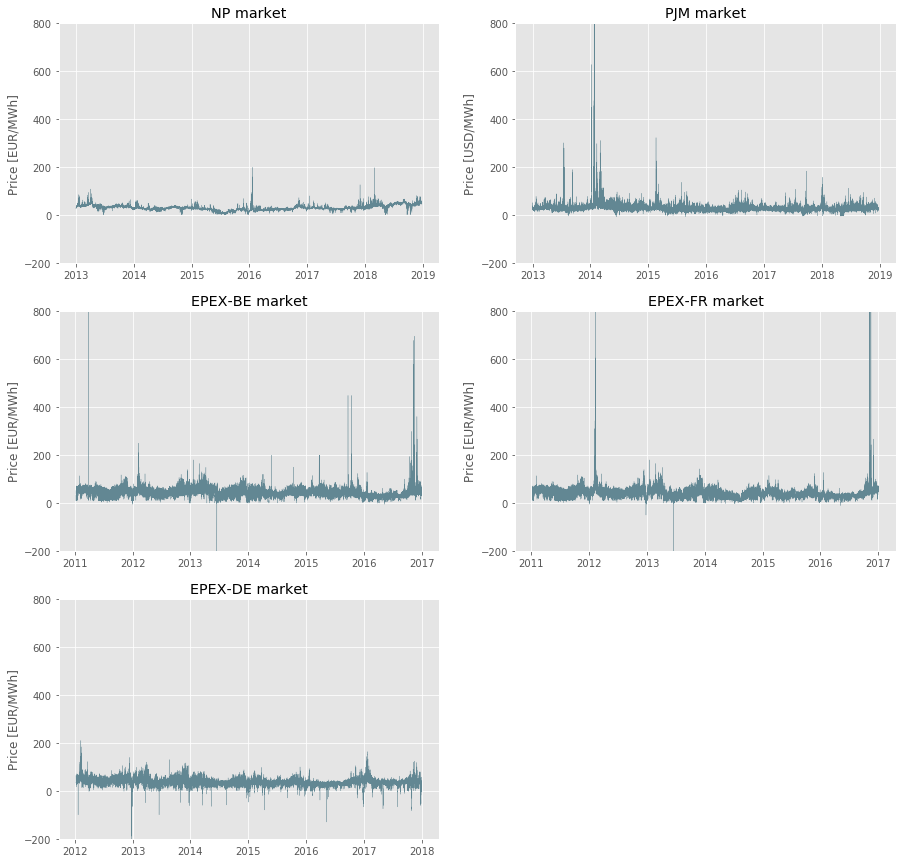

In [ ]:
import pylab as plt
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = 15, 15

from nixtla.data.datasets.epf import EPF, EPFInfo

dataset = ['NP', 'PJM', 'BE', 'FR', 'DE']
Y_df, X_df, S_df = EPF.load_groups(directory='data', groups=dataset)

plt.ylim(-200, 800)
rcParams['figure.figsize'] = 15, 15
ax0 = plt.subplot2grid((3,2),(0, 0))
ax1 = plt.subplot2grid((3,2),(0, 1))
ax2 = plt.subplot2grid((3,2),(1, 0))
ax3 = plt.subplot2grid((3,2),(1, 1))
ax4 = plt.subplot2grid((3,2),(2, 0))
axs = [ax0, ax1, ax2, ax3, ax4]

for idx, market in enumerate(dataset):
    currency = 'USD' if market == 'PJM' else 'EUR'
    title_str  = 'EPEX-' if not (market in ['PJM', 'NP']) else ''
    title_str += f'{market} market'
    y_axis_str = f'Price [{currency}/MWh]'

    x_plot = Y_df[Y_df.unique_id==market].ds
    y_plot = Y_df[Y_df.unique_id==market].y


    axs[idx].plot(x_plot, y_plot, color='#628793', linewidth=0.3)
    # ax.set_xlabel('xlabel', fontsize=10)
    axs[idx].set_ylabel(y_axis_str)
    axs[idx].set_title(title_str)
    axs[idx].set_ylim(-200,800)

plt.savefig('./results/market_plots.png', bbox_inches = 'tight')
plt.show()